<a href="https://colab.research.google.com/github/zhuzihan728/COMP0138-Metal-Binding-Site-Prediction/blob/main/colab_scripts/explore_biopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Import Libs

In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os  
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr

# Extract datasets

In [ ]:
%env MY_PATH=/content/drive/MyDrive/FYP

env: MY_PATH=/content/drive/MyDrive/FYP


In [ ]:
import os

my_path = os.environ['MY_PATH']   
my_path

'/content/drive/MyDrive/FYP'

In [ ]:
!tar -xvf /content/drive/MyDrive/FYP/uniprot_datasets

ChEBI-IDs_for_metal_binding.tsv
NEG_clustered_rep_seq.fasta
NEG_TRAIN.fasta
POS_TRAIN.fasta
POS_TRAIN_FULL.fasta
POS_TRAIN_FULL.tsv
POS_TRAIN.tsv
filtered_combined.fasta
trimed_combined.fasta


In [ ]:
!cat NEG_TRAIN.fasta	POS_TRAIN.fasta > combined.fasta

In [ ]:
total_len = len(list(SeqIO.parse("/content/combined.fasta", "fasta")))
print("Full data set size: ", total_len)

Full data set size:  195450


## Data File Description
ChEBI-IDs_for_metal_binding.tsv: 29 metal ions and their ChEBI-ID.  
  \
POS_TRAIN_FULL.tsv: annotated protein metal binding sites for POS_TRAIN_FULL.fasta.  
  \
POS_TRAIN.tsv: annotated protein metal binding sites for POS_TRAIN.fasta.  
  \
NEG_TRAIN.fasta: negative protein sequences.  
  \
POS_TRIAN.fasta: positive protein sequences annotated by evidence ECO:0000269 and ECO:0007744 from UniProtKB/Swiss-Prot, s subset of POS_TRAIN_FULL.fasta.  
  \
POS_TRAIN_FULL.fasta: all positive protein sequences from UniProtKB/Swiss-Prot, containing POS_TRIAN.fasta.

# Helper functions

In [ ]:
def check_metal_per(seqs, metal, anno, metal_count_df):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  per = cnt / int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
  return per

In [ ]:
def check_metal_num(seqs, metal, anno):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  return cnt

In [ ]:
def check_metal_specific_residue_proportion(acc_ls, source = 'POS_TRAIN_FULL.tsv'):
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  for metal in metal_count_df['ChEBI-ID'].unique():
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    num = check_metal_num(acc_ls, metal, anno) 
    total_num = int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
    print(f'{metal:12}| {metal_name:29} | num: {int(num):6} | %: {num/total_num}')

In [ ]:
def write_seq_ls2fasta(file_out, ls, source):
  with open(file_out, 'w') as f_out:
    for seq_record in SeqIO.parse(source, "fasta"):
      seq_acc = seq_record.id.split('|')[1]
      if seq_acc in ls:
        r = SeqIO.write(seq_record, f_out, 'fasta')

        if r!=1: 
          print('Error while writing sequence: ' + seq_acc)
        else:
          print(f'writing {seq_acc} to train fasta file.')

In [ ]:
def fasta2acc_seq_ls(path):
  acc = []
  seq = []

  for seq_record in SeqIO.parse(path, "fasta"):
    acc.append(seq_record.id.split('|')[1])
    seq.append(str(seq_record.seq))
  return acc, seq

In [ ]:
def check_pos_neg_proportion(ls):
  total_num = len(ls)
  
  acc, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  inter = set(acc).intersection(ls)
  pos_num = len(inter)
  neg_num = total_num - pos_num
  pos_portion = pos_num/total_num
  neg_portion = neg_num/total_num
  print(f'total seq in the set: {total_num}')
  print(f'proportion over full dataset: {total_num/total_len}')
  print(f'pos: {pos_num} %: {pos_portion}')
  print(f'neg: {neg_num} %: {neg_portion}')
  return total_num, pos_num, neg_num, pos_portion, neg_portion

In [ ]:
def identity_above_threshold(m8file, thres):
  data = pd.read_csv(m8file, sep="\t", index_col=False, header=None)
  data.columns = ["query", "target","sequence identity","alignment length","mismatch","gap opening", "query domain start position", "end position","target domain start position", "end position", "evalue", "bit score"]
  
  seq_above_thres = data[data["sequence identity"] > thres]["query"].unique()
  seq_below_thres = data[~data["query"].isin(seq_above_thres)]["query"].unique()
  # print(data[data["sequence identity"] > thres]["sequence identity"].unique())
  all_seq = data["query"].unique()
  proportion = len(seq_above_thres) / len(all_seq)
  print(len(all_seq) == len(seq_above_thres) + len(seq_below_thres))
  return seq_above_thres, seq_below_thres, proportion

In [ ]:
def read_fasta(fasta_path, split_char="|", id_field=1):
    '''
        Reads in fasta file containing multiple sequences.
        Split_char and id_field allow to control identifier extraction from header.
        E.g.: set split_char="|" and id_field=1 for SwissProt/UniProt Headers.
        Returns dictionary holding multiple sequences or only single 
        sequence, depending on input file.
    '''
    
    seqs = dict()
    with open( fasta_path, 'r' ) as fasta_f:
        for line in fasta_f:
            # get uniprot ID from header and create new entry
            if line.startswith('>'):
                uniprot_id = line.replace('>', '').strip().split(split_char)[id_field]
                # replace tokens that are mis-interpreted when loading h5
                uniprot_id = uniprot_id.replace("/","_").replace(".","_")
                seqs[ uniprot_id ] = ''
            else:
                # repl. all whie-space chars and join seqs spanning multiple lines, drop gaps and cast to upper-case
                seq= ''.join( line.split() ).upper().replace("-","")
                # repl. all non-standard AAs and map them to unknown/X
                seq = seq.replace('U','X').replace('Z','X').replace('O','X')
                seqs[ uniprot_id ] += seq 
    example_id=next(iter(seqs))
    print("Read {} sequences.".format(len(seqs)))
    print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

    return seqs

In [ ]:
def dataset_metal_binding_summary(acc_ls, source = 'POS_TRAIN_FULL.tsv'):
  total_num = len(acc_ls)
  print(f'total seq in the set: {total_num}')

  all_pos_acc_ls, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  metals = {'CHEBI:29105':0,'CHEBI:18420':1,'CHEBI:49883':2,'CHEBI:29108':3,'CHEBI:29035':4,'CHEBI:60240':5,'CHEBI:24875':6,'CHEBI:190135':7,'CHEBI:23378':8,'CHEBI:29103':9,'CHEBI:49786':10,'CHEBI:29101':11,'CHEBI:29034':12,'CHEBI:30408':13,'CHEBI:29036':14,'CHEBI:29033':15,'CHEBI:21137':16,'CHEBI:49552':17,'CHEBI:48775':18,'CHEBI:48828':19,'CHEBI:21143':20,'CHEBI:25213':21,'CHEBI:47739':22,'CHEBI:16793':23,'CHEBI:177874':24,'CHEBI:60400':25,'CHEBI:49415':26,'CHEBI:60504':27,'CHEBI:49713':28}
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  prot_counter = [0]*29 
  res_counter = [0]*29
  pos_acc = set(all_pos_acc_ls).intersection(acc_ls)
  for i, metal in enumerate(metals):
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    temp = anno[anno['ChEBI-ID'] == metal]
    prot_counter[i] += len(temp[temp['Accession'].isin(pos_acc)]['Accession'].unique())
    res_counter[i] += check_metal_num(acc_ls, metal, anno)
    total_res_num = int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
    print(f"{metal:13}|{metal_name:30}|#p: {prot_counter[i]:10}|#residue: {res_counter[i]:6}|%residue/all: {res_counter[i]/total_res_num:{5}.{3}}")
  print(f"#non-binding protein: {total_num-len(pos_acc)}")
  return prot_counter, res_counter


# Data preview

ls: all proteins in POS_TRAIN_FULL.fasta.

In [ ]:
pos_dic = read_fasta('POS_TRAIN.fasta', split_char="|", id_field=1)
pos_acc = list(pos_dic.keys())
pos_seq = list(pos_dic.values())
print(pos_acc[0])
print(pos_seq[0])

Read 2317 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


In [ ]:
neg_dic = read_fasta('NEG_TRAIN.fasta', split_char="|", id_field=1)
neg_acc = list(neg_dic.keys())
neg_seq = list(neg_dic.values())
print(neg_acc[0])
print(neg_seq[0])

Read 193133 sequences.
Example:
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP


In [ ]:
full_dic = read_fasta('combined.fasta', split_char="|", id_field=1)
full_acc = list(full_dic.keys())
full_seq = list(full_dic.values())
print(full_acc[0])
print(full_seq[0])

Read 195450 sequences.
Example:
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP


# Dataset Preview

In [ ]:
full_dic = read_fasta('combined.fasta', split_char="|", id_field=1)
full_acc = list(full_dic.keys())
full_seq = list(full_dic.values())

Read 195450 sequences.
Example:
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP


In [ ]:
prot_df = pd.DataFrame({'Accession': full_acc, 'Prot_seq': full_seq})
 
label_df = pd.read_csv('POS_TRAIN.tsv', sep='\t')
 
metal_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')

In [ ]:
#@title Full (positive + negative) proteins. { display-mode: "form" }
prot_df

,Accession,Prot_seq
0,A0A075B6S6,MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSS...
1,A0A0K0IP23,MMSTMSIKEGLLVILLSLFLFDTTALIHRREIPHMESKGQMQRGQV...
2,A3DA80,MNLAAMDPQTYDTQLEHKRIKLEQAFAQFETPSVEVFASEPANYRM...
3,A3KGV1,MSASSSGGSPRFPSCGKNGVTSLTQKKVLRTPCGAPSVTVTKSHKR...
4,A3MRU9,MPTINQLVRKGRASETTKSKSPALQDCPQRRGVCTRVYTTTPKKPN...
...,...,...
195445,T2KPK5,MTNMNLKHKIFIMLLLVFCSSKIIAQQSQPNVLVFYVDDLRAELGC...
195446,U3FAE1,MKTLLLTLVVVTIVCLDLGNSLKCYSSRTETMTCPEGEDKCEKYAV...
195447,U3KRG1,QQRFPQRYVMLAIVADHGMVTKYSGNSSAITTRVHQMVSHVTEMYS...
195448,V9VGU0,MAFVSLLTILLAISSSSVALTEPVASMADQGVFPEQHGRGHHGVFP...


In [ ]:
#@title All labels. { display-mode: "form" }
label_df

,Accession,Evidence,ChEBI-ID,Position
0,Q8INK9,ECO:0000269,CHEBI:29105,157
1,Q8INK9,ECO:0000269,CHEBI:29105,96
2,Q1QT89,ECO:0000269,CHEBI:18420,263
3,P07327,ECO:0000269,CHEBI:29105,101
4,P07327,ECO:0007744,CHEBI:29105,104
...,...,...,...,...
18038,P62339,ECO:0000269,CHEBI:60240,43
18039,P62339,ECO:0000269,CHEBI:60240,23
18040,P62339,ECO:0007744,CHEBI:60240,32
18041,P62339,ECO:0000269,CHEBI:60240,40


In [ ]:
#@title All metal types. { display-mode: "form" }
metal_df

,ChEBI-ID,Name,ChEBI-ID Parents
0,CHEBI:48775,Cd(2+),"CHEBI:60240,CHEBI:25213"
1,CHEBI:29108,Ca(2+),"CHEBI:60240,CHEBI:25213"
2,CHEBI:48828,Co(2+),"CHEBI:60240,CHEBI:25213"
3,CHEBI:49415,Co(3+),CHEBI:25213
4,CHEBI:23378,Cu cation,CHEBI:25213
5,CHEBI:49552,Cu(+),"CHEBI:23378,CHEBI:25213"
6,CHEBI:29036,Cu(2+),"CHEBI:23378,CHEBI:60240,CHEBI:25213"
7,CHEBI:60240,a divalent metal cation,CHEBI:25213
8,CHEBI:190135,[2Fe-2S] cluster,CHEBI:30408
9,CHEBI:24875,Fe cation,CHEBI:25213


In [ ]:
#@title Merged data and labels.
prot_label_df = pd.merge(prot_df, label_df, on = "Accession", how = "outer")
prot_metal_df =  pd.merge(prot_label_df, metal_df, on = "ChEBI-ID", how = "outer")
prot_metal_df = prot_metal_df.dropna()
prot_metal_df

,Accession,Prot_seq,Evidence,ChEBI-ID,Position,Name,ChEBI-ID Parents
193133,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,12.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
193134,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,10.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
193135,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,19.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
193136,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,14.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
193137,A0A067XG71,ADTIVAVELDTYPNTDIGDPNYPHIGIDIKSIRSKKIAKWNMQDGK...,ECO:0007744,CHEBI:29108,12.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
...,...,...,...,...,...,...,...
211171,Q9F8A8,MAKQNLKSTDRAVQQMLDKAKREGIQTVWDRYEAMKPQCGFGETGL...,ECO:0000269,CHEBI:177874,261.0,[Ni-4Fe-5S] cluster,"CHEBI:60400,CHEBI:30408"
211172,Q9F8A8,MAKQNLKSTDRAVQQMLDKAKREGIQTVWDRYEAMKPQCGFGETGL...,ECO:0000269,CHEBI:177874,526.0,[Ni-4Fe-5S] cluster,"CHEBI:60400,CHEBI:30408"
211173,Q9F8A8,MAKQNLKSTDRAVQQMLDKAKREGIQTVWDRYEAMKPQCGFGETGL...,ECO:0000269,CHEBI:177874,446.0,[Ni-4Fe-5S] cluster,"CHEBI:60400,CHEBI:30408"
211174,Q9F8A8,MAKQNLKSTDRAVQQMLDKAKREGIQTVWDRYEAMKPQCGFGETGL...,ECO:0000269,CHEBI:177874,476.0,[Ni-4Fe-5S] cluster,"CHEBI:60400,CHEBI:30408"


# Metal Occurrence Analysis

In [ ]:
font = {'size'   : 20}

plt.rc('font', **font)
import seaborn as sns
import seaborn.objects as so
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


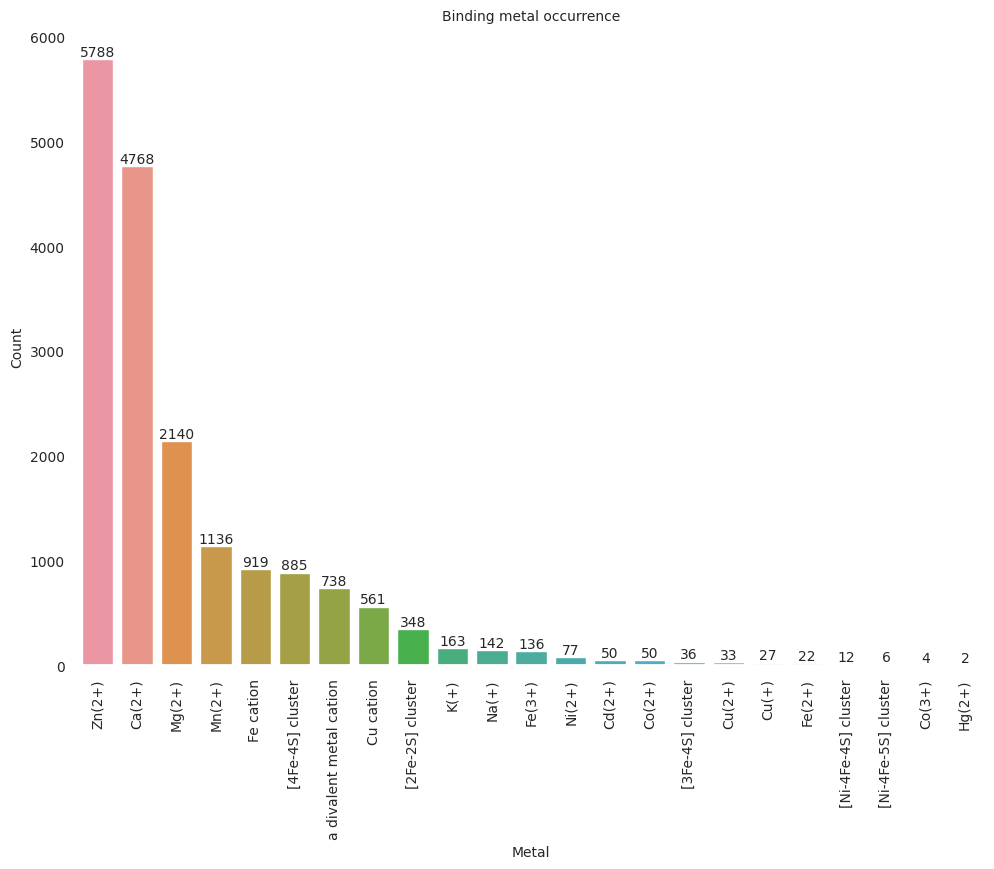

In [ ]:
metal_count_df = prot_metal_df[['Name', 'ChEBI-ID']].value_counts().to_frame().reset_index().rename(columns={'Name':'Metal', 0:'Count'})
# metal_count_df.plot(x="Metal", y="Count", kind="bar", figsize=(29,10), fontsize=20, title='metal binding residue count')
# metal_count_df
ax = sns.barplot(data=metal_count_df, x='Metal',  y='Count')
# drawing the plot
ax.bar_label(ax.containers[0], fontsize=10)
# drawing the plot
# sns.displot(prot_metal_df, x='Name', binwidth=3, height=4, aspect=2.4)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(fontsize=10)
plt.xlabel("Metal", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.title("Binding metal occurrence", fontsize=10)
plt.show()
# hg2 -> 5
# co3+, Li -> a metal cation
# fs - 3f4s -> iron-sulfur cluster
# 


In [ ]:
dataset_metal_binding_summary(pos_acc)
pass

total seq in the set: 2317
CHEBI:29105  |Zn(2+)                        |#p:        805|#residue:   7157|%residue/all: 0.0535
CHEBI:18420  |Mg(2+)                        |#p:        566|#residue:   2686|%residue/all:  0.03
CHEBI:49883  |[4Fe-4S] cluster              |#p:        121|#residue:   1035|%residue/all: 0.0201
CHEBI:29108  |Ca(2+)                        |#p:        425|#residue:   5729|%residue/all: 0.136
CHEBI:29035  |Mn(2+)                        |#p:        209|#residue:   1322|%residue/all: 0.0589
CHEBI:60240  |a divalent metal cation       |#p:         88|#residue:    859|%residue/all: 0.0472
CHEBI:24875  |Fe cation                     |#p:        175|#residue:   1141|%residue/all: 0.0654
CHEBI:190135 |[2Fe-2S] cluster              |#p:         57|#residue:    427|%residue/all: 0.0473
CHEBI:23378  |Cu cation                     |#p:         87|#residue:    616|%residue/all: 0.0833
CHEBI:29103  |K(+)                          |#p:         25|#residue:    185|%residue/all: 0.

## Binding Metal Counts of Proteins

In [ ]:
prot_count_df = prot_metal_df['Accession'].value_counts().to_frame().reset_index().rename(columns={'index':'Accession', 'Accession':'#binding sites'})
prot_count_df

,Accession,#binding sites
0,O31526,88
1,O31527,76
2,E0VIU9,64
3,Q868M7,62
4,Q51817,56
...,...,...
2312,Q8NK92,1
2313,P51553,1
2314,Q9HYC4,1
2315,Q5D1E8,1


A0A023GPI8  CHEBI:29108        10 \
A0A023GPI8  CHEBI:29035        10 \
shows **one protein can bind two different metals at the same position, provided by the same evidence**.

In [ ]:
np.mean([i for i in prot_count_df['#binding sites']])

7.7872248597324125

<ipython-input-223-7520cc9e7384>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(y=[0], x = mean_, xerr = std_, fmt='.k', ecolor='steelblue', lw=1, capsize=3,  c='steelblue')
<ipython-input-223-7520cc9e7384>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prot_count_df['#binding sites'], hist = False, kde = True,
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.

Text(0, 0.5, 'Density')

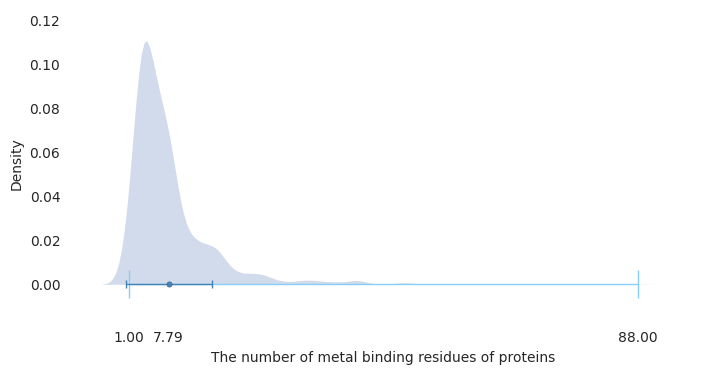

In [ ]:

# construct some data like what you have:
x = np.asarray([i for i in prot_count_df['#binding sites']])
min_ = x.min()
max_ = x.max()
mean_ = x.mean()
std_ = x.std()
# create stacked errorbars:
plt.figure(figsize=(8,4))

plt.errorbar(y=[0], x = mean_, xerr = [[mean_ - min_], [max_ - mean_]], capsize=10,
             fmt='.k', ecolor='lightskyblue', lw=1)
plt.errorbar(y=[0], x = mean_, xerr = std_, fmt='.k', ecolor='steelblue', lw=1, capsize=3,  c='steelblue')
sns.distplot(prot_count_df['#binding sites'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 0})
plt.xticks([min_, mean_, max_],fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([-0.015, 0.125])
# plt.title("Protein metal binding residue number",fontsize=10)
plt.xlabel("The number of metal binding residues of proteins",fontsize=10)
plt.ylabel("Density", fontsize=10)

In [ ]:
temp = prot_metal_df[['Accession', 'ChEBI-ID', 'Position']].dropna(how='any')
temp[temp['Accession']=='A0A023GPI8']

,Accession,ChEBI-ID,Position
193133,A0A023GPI8,CHEBI:29108,12.0
193134,A0A023GPI8,CHEBI:29108,10.0
193135,A0A023GPI8,CHEBI:29108,19.0
193136,A0A023GPI8,CHEBI:29108,14.0
197901,A0A023GPI8,CHEBI:29035,10.0
197902,A0A023GPI8,CHEBI:29035,8.0
197903,A0A023GPI8,CHEBI:29035,24.0
197904,A0A023GPI8,CHEBI:29035,19.0


The maximum types of metal one seq can bind is 3.

In [ ]:
# max_num = -1
# for i in range(len(prot_df)):
#   prot = prot_df['Accession'].iloc[i]
#   num = len(temp[temp['Accession'] == prot]['ChEBI-ID'].unique())
#   max_num = max(max_num, num)
# print(max_num)

# Protein Length Analysis

In [ ]:
prot_len_df = pd.DataFrame({'Accession':prot_df['Accession'], 'Prot_seq': prot_df['Prot_seq'], 'Length':[len(i) for i in prot_df['Prot_seq']]})
prot_len_df

,Accession,Prot_seq,Length
0,A0A075B6S6,MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSS...,120
1,A0A0K0IP23,MMSTMSIKEGLLVILLSLFLFDTTALIHRREIPHMESKGQMQRGQV...,161
2,A3DA80,MNLAAMDPQTYDTQLEHKRIKLEQAFAQFETPSVEVFASEPANYRM...,365
3,A3KGV1,MSASSSGGSPRFPSCGKNGVTSLTQKKVLRTPCGAPSVTVTKSHKR...,830
4,A3MRU9,MPTINQLVRKGRASETTKSKSPALQDCPQRRGVCTRVYTTTPKKPN...,126
...,...,...,...
195445,T2KPK5,MTNMNLKHKIFIMLLLVFCSSKIIAQQSQPNVLVFYVDDLRAELGC...,488
195446,U3FAE1,MKTLLLTLVVVTIVCLDLGNSLKCYSSRTETMTCPEGEDKCEKYAV...,84
195447,U3KRG1,QQRFPQRYVMLAIVADHGMVTKYSGNSSAITTRVHQMVSHVTEMYS...,202
195448,V9VGU0,MAFVSLLTILLAISSSSVALTEPVASMADQGVFPEQHGRGHHGVFP...,463


In [ ]:
np.min(prot_len_df['Length'])

2

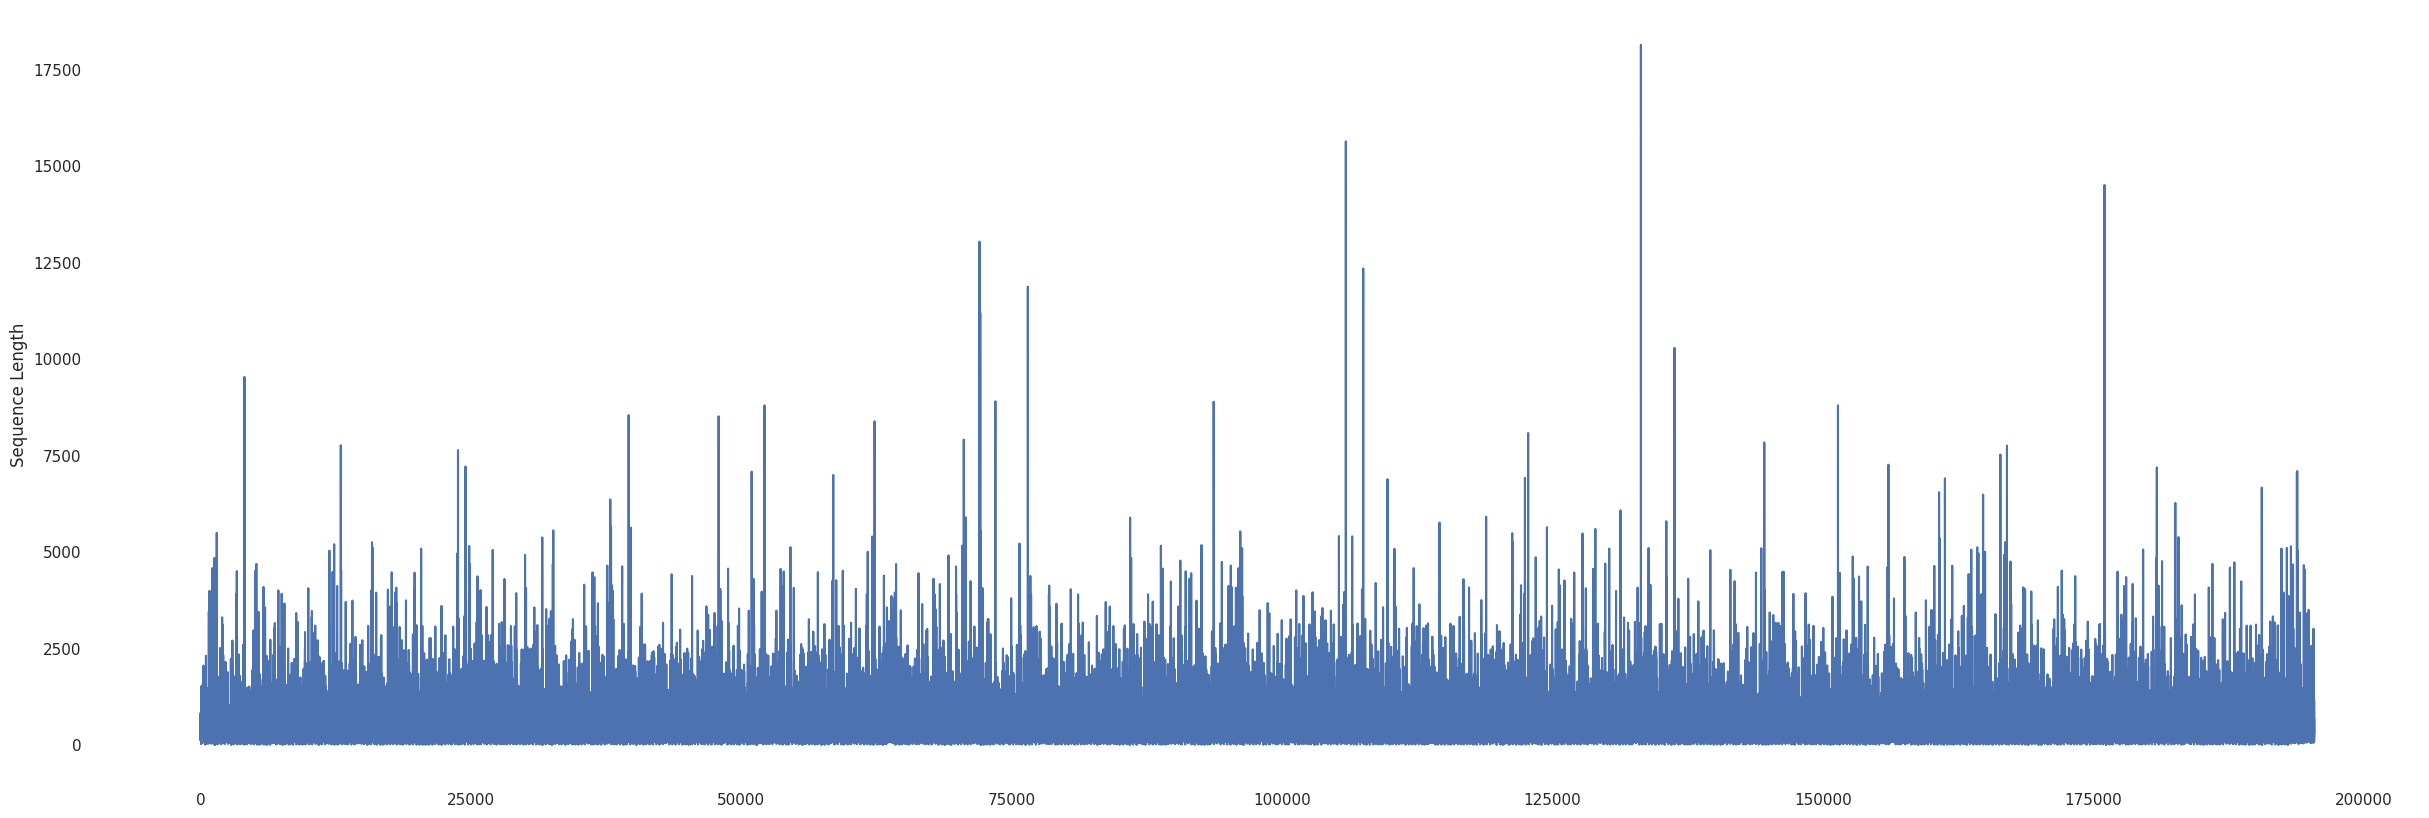

In [ ]:
# Plot out the data
plt.figure(figsize=(30, 10))
plt.plot(prot_len_df['Length'])
plt.ylabel('Sequence Length')
plt.show()

383.27958330170264


<ipython-input-317-c444a9dae3e8>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(y=[0], x = mean_, xerr = std_, fmt='.k', ecolor='steelblue', lw=1, capsize=3,  c='steelblue')
<ipython-input-317-c444a9dae3e8>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prot_len_df['Length'], hist = False, kde = True,
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; plea

Text(0, 0.5, 'Density')

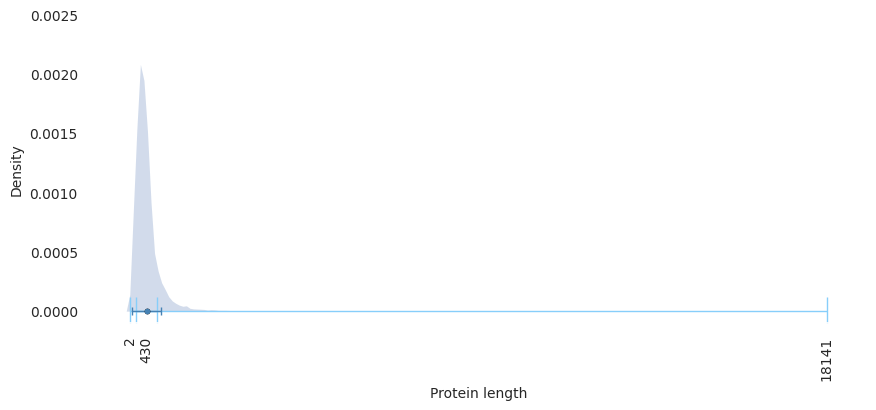

In [ ]:
# construct some data like what you have:
x = np.asarray([i for i in prot_len_df['Length']])
min_ = x.min()
max_ = x.max()
mean_ = x.mean()
std_ = x.std()
iqr_ = 271.0
print(std_)
# create stacked errorbars:
plt.figure(figsize=(10,4))

plt.errorbar(y=[0], x = mean_, xerr = [[mean_ - min_], [max_ - mean_]], capsize=10,
             fmt='.k', ecolor='lightskyblue', lw=1)
plt.errorbar(y=[0], x = mean_, xerr = iqr_, capsize=10, fmt='.k', ecolor='lightskyblue', lw=1)
plt.errorbar(y=[0], x = mean_, xerr = std_, fmt='.k', ecolor='steelblue', lw=1, capsize=3,  c='steelblue')
sns.distplot(prot_len_df['Length'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 0})
plt.xticks([min_, mean_, max_],fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.ylim([-0.0001, 0.0025])
# plt.title("Protein metal binding residue number",fontsize=10)
plt.xlabel("Protein length",fontsize=10)
plt.ylabel("Density", fontsize=10)

## explore correlation between length and metal binding site number

In [ ]:
prot_len_cnt_df = pd.merge(prot_count_df, prot_len_df, on = "Accession", how = "inner")
prot_len_cnt_df

,Accession,#binding sites,Prot_seq,Length
0,O31526,88,MRRSCLMIRRRKRMFTAVTLLVLLVMGTSVCPVKAEGAARQMEALN...,620
1,O31527,76,MKPKKRQMEYLTRGLIAVQTEQGVFVSWRFLGTDHETTAFHLYRDG...,612
2,E0VIU9,64,MSILEWFWNILCGMAQYLTFSKNLTNDNLVNIYVKSNVGGTISVNL...,461
3,Q868M7,62,MVSLVPCGFAQVLCTNPLDIGELRNYKSKQCVDIVGNQGSGNIATH...,442
4,Q51817,56,MRKLLLLIAASLLGVGLYAQSAKIKLDAPTTRTTCTNNSFKQFDAS...,1732
...,...,...,...,...
2312,Q8NK92,1,MRPLSHLSFFNGLLLGLSALSAATSVVHERREATSSNWVKRARVNP...,652
2313,P51553,1,MALKVATVAGSAAKAVLGPALLCRPWEVLGAHEVPSRNIFSEQTIP...,393
2314,Q9HYC4,1,MKTVALILASLALLACTAESGVDFDKTLTHPNGLVVERPVGFDARR...,145
2315,Q5D1E8,1,MSGPCGEKPVLEASPTMSLWEFEDSHSRQGTPRPGQELAAEEASAL...,599


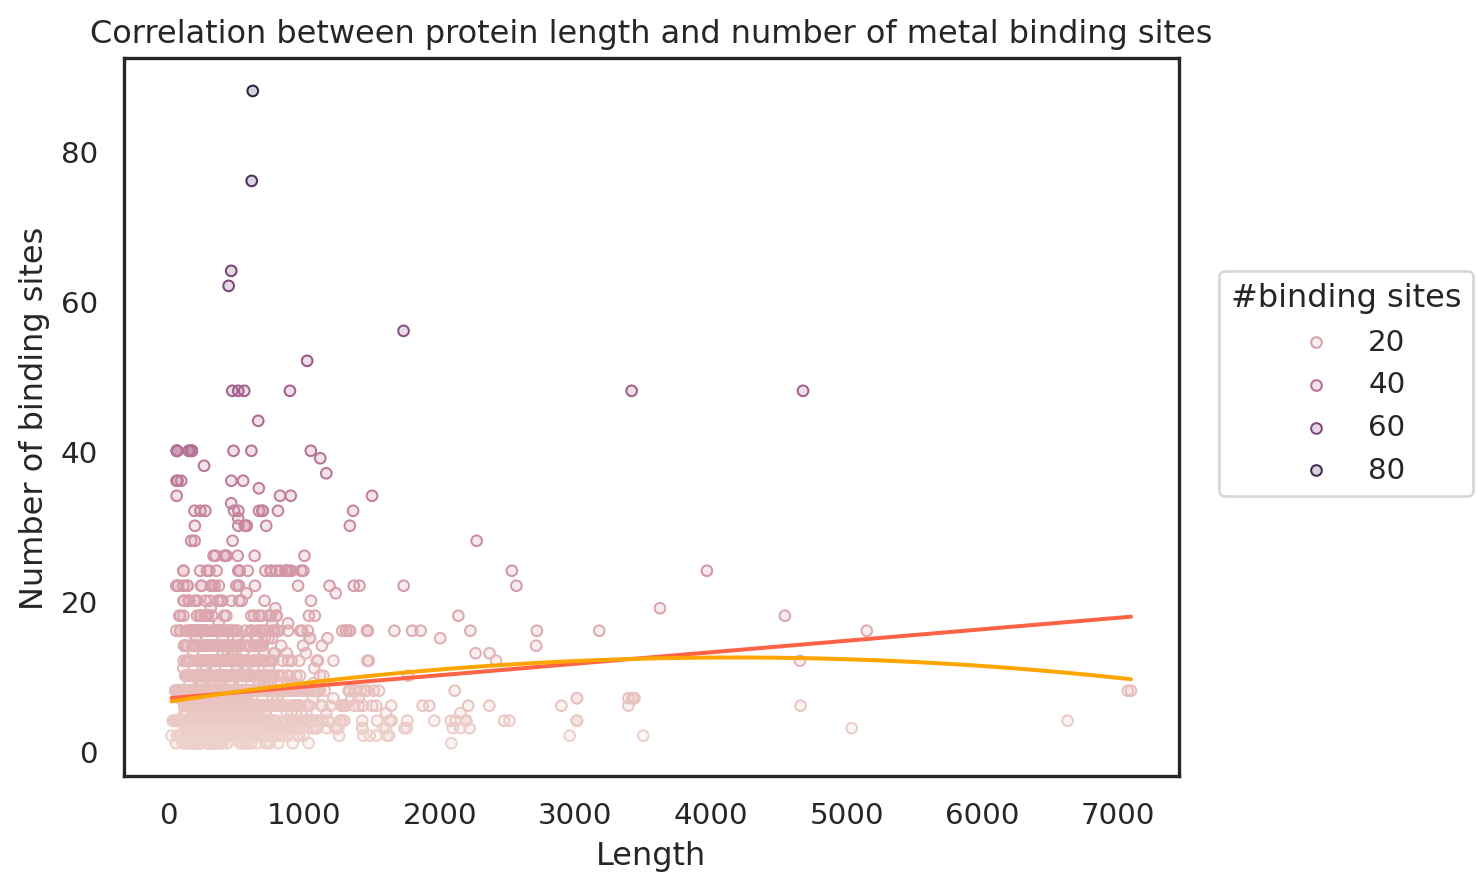

In [ ]:

so.Plot()
p = (
    so.Plot(prot_len_cnt_df, 'Length', '#binding sites').add(so.Dots(), color='#binding sites').add(so.Line(color="tomato"), so.PolyFit(order=1)).add(so.Line(color="orange"), so.PolyFit(order=2)).theme({**sns.axes_style("white")})
)

p.label(x="Length", y="Number of binding sites", title="Correlation between protein length and number of metal binding sites")
# plt.scatter(prot_len_cnt_df['Length'], prot_len_cnt_df['#binding sites'])
# plt.xlabel('Length')
# plt.ylabel('#binding site')
# plt.title("correlation between protein length and their binding site number")
# plt.show()

**No evident clue that protein length and their binding site number are related.**

## Check MN ZN 2FE2S

In [ ]:
all = list(label_df['Accession'].unique())

In [ ]:
pos_dic = read_fasta(r'/content/POS_TRAIN.fasta', split_char="|", id_field=1)

Read 2317 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


In [ ]:
mn = label_df[label_df['ChEBI-ID'] == 'CHEBI:29035']['Accession'].unique()

In [ ]:
fe = label_df[label_df['ChEBI-ID'] == 'CHEBI:24875']['Accession'].unique()

In [ ]:
len(label_df[(label_df['Accession'].isin(fe)) & (label_df['ChEBI-ID'] != 'CHEBI:24875')])

233

In [ ]:
len(label_df[(label_df['Accession'].isin(mn)) & (label_df['ChEBI-ID'] != 'CHEBI:29035')])

287

In [ ]:
all_mn_binding = label_df[(label_df['Accession'].isin(mn)) & (label_df['ChEBI-ID'] == 'CHEBI:29035')]

In [ ]:
all_mn_binding

,Accession,Evidence,ChEBI-ID,Position
14,Q6TEC1,ECO:0000269,CHEBI:29035,150
26,P0AAB4,ECO:0000269,CHEBI:29035,175
89,P46637,ECO:0000269,CHEBI:29035,161
131,Q7NXD4,ECO:0000269,CHEBI:29035,248
146,P36873,ECO:0000269,CHEBI:29035,92
...,...,...,...,...
17946,A0A067XG71,ECO:0007744,CHEBI:29035,10
17986,P9WH69,ECO:0000269,CHEBI:29035,68
17987,P22259,ECO:0000269,CHEBI:29035,269
18000,A0A1L7NQ96,ECO:0000269,CHEBI:29035,240


In [ ]:
ls = []
for index, row in all_mn_binding.iterrows():
  ls.append(pos_dic[row['Accession']][row['Position']-1])


In [ ]:
all_mn_binding['Mn(2+) binding site'] = ls

<ipython-input-147-fb12dc416b93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_mn_binding['Mn(2+) binding site'] = ls


In [ ]:
all_mn_binding

,Accession,Evidence,ChEBI-ID,Position,binding site
14,Q6TEC1,ECO:0000269,CHEBI:29035,150,E
26,P0AAB4,ECO:0000269,CHEBI:29035,175,N
89,P46637,ECO:0000269,CHEBI:29035,161,H
131,Q7NXD4,ECO:0000269,CHEBI:29035,248,D
146,P36873,ECO:0000269,CHEBI:29035,92,D
...,...,...,...,...,...
17946,A0A067XG71,ECO:0007744,CHEBI:29035,10,D
17986,P9WH69,ECO:0000269,CHEBI:29035,68,E
17987,P22259,ECO:0000269,CHEBI:29035,269,D
18000,A0A1L7NQ96,ECO:0000269,CHEBI:29035,240,E


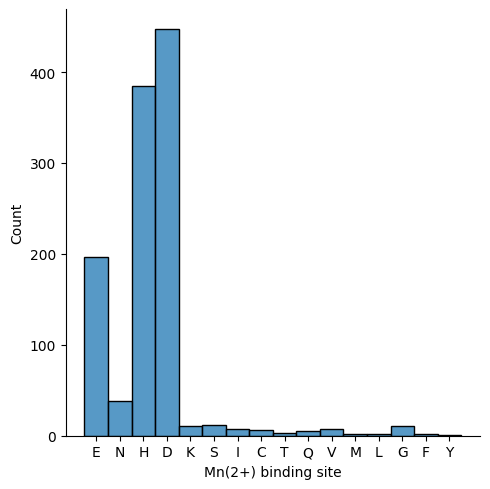

In [ ]:
sns.displot(data = all_mn_binding, x = 'Mn(2+) binding site')

In [ ]:
all_fe_binding = label_df[(label_df['Accession'].isin(fe)) & (label_df['ChEBI-ID'] == 'CHEBI:24875')]

In [ ]:
ls = []
for index, row in all_fe_binding.iterrows():
  ls.append(pos_dic[row['Accession']][row['Position']-1])


In [ ]:
all_fe_binding['Fe binding site'] = ls

<ipython-input-151-ac702fd05fd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_fe_binding['Fe binding site'] = ls


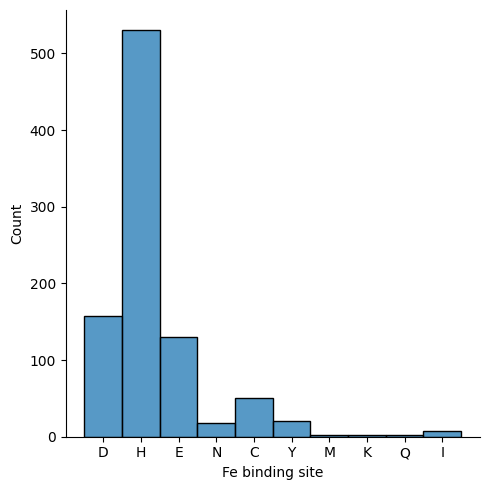

In [ ]:
sns.displot(data = all_fe_binding, x = 'Fe binding site')

In [ ]:
not_mn = [x for x in all if x not in list(mn)]

In [ ]:
not_fe = [x for x in all if x not in list(fe)]

In [ ]:
len(set(mn).intersection(not_mn))

45

In [ ]:
len(set(fe).intersection(not_fe))

31

In [ ]:
write_seq_ls2fasta('mn.fasta', mn, '/content/POS_TRAIN.fasta')

writing A0A023GPI8 to train fasta file.
writing A0A067XG71 to train fasta file.
writing A0A0H2URJ6 to train fasta file.
writing A0A0H3JNB0 to train fasta file.
writing A0A0H3JPC6 to train fasta file.
writing A0A0H3JRU9 to train fasta file.
writing A0A0H3NK84 to train fasta file.
writing A0A1C9J6A7 to train fasta file.
writing A0A1L7NQ96 to train fasta file.
writing A0A256XLS3 to train fasta file.
writing A0A6M7H989 to train fasta file.
writing A0NLY7 to train fasta file.
writing A2QHE5 to train fasta file.
writing A5HC98 to train fasta file.
writing A5TYT6 to train fasta file.
writing A6VKV4 to train fasta file.
writing A8BQJ3 to train fasta file.
writing A9CH28 to train fasta file.
writing B1WBP0 to train fasta file.
writing B7UI21 to train fasta file.
writing B8I944 to train fasta file.
writing B9KDD4 to train fasta file.
writing B9WJ66 to train fasta file.
writing C0HJX1 to train fasta file.
writing C0HJY1 to train fasta file.
writing C0HK81 to train fasta file.
writing D6WI29 to tr

In [ ]:
write_seq_ls2fasta('not_mn.fasta', not_mn, '/content/POS_TRAIN.fasta')

writing A0A084JZF2 to train fasta file.
writing A0A096P8D3 to train fasta file.
writing A0A0D4WV12 to train fasta file.
writing A0A0F5HNH9 to train fasta file.
writing A0A0H2UMY0 to train fasta file.
writing A0A0H2UNG0 to train fasta file.
writing A0A0H2URD6 to train fasta file.
writing A0A0H2VDN9 to train fasta file.
writing A0A0H2WWB5 to train fasta file.
writing A0A0H3AIG7 to train fasta file.
writing A0A0H3JUU7 to train fasta file.
writing A0A0H3KB22 to train fasta file.
writing A0A0K8P8E7 to train fasta file.
writing A0A109PTH9 to train fasta file.
writing A0A1C7D1B7 to train fasta file.
writing A0A1E1FFL0 to train fasta file.
writing A0A1H7TQR5 to train fasta file.
writing A0A1L4BKS3 to train fasta file.
writing A0A1L8F5J9 to train fasta file.
writing A0A1W2VMZ5 to train fasta file.
writing A0A2D0TC04 to train fasta file.
writing A0A2I4HXH5 to train fasta file.
writing A0A2K3D5Z7 to train fasta file.
writing A0A384KG77 to train fasta file.
writing A0A386KZ50 to train fasta file.


In [ ]:
write_seq_ls2fasta('fe.fasta', fe, '/content/POS_TRAIN.fasta')

writing A0A1E1FFL0 to train fasta file.
writing A0A2K3D5Z7 to train fasta file.
writing C8VSZ2 to train fasta file.
writing D0E8I5 to train fasta file.
writing D0VWR8 to train fasta file.
writing F1CMX0 to train fasta file.
writing F1CMY8 to train fasta file.
writing F2RB80 to train fasta file.
writing F2RB83 to train fasta file.
writing F4KIX0 to train fasta file.
writing F6BCS4 to train fasta file.
writing G7CFI3 to train fasta file.
writing G8GV69 to train fasta file.
writing I6XD65 to train fasta file.
writing I6YEE1 to train fasta file.
writing O00625 to train fasta file.
writing O14607 to train fasta file.
writing O14832 to train fasta file.
writing O15296 to train fasta file.
writing O15550 to train fasta file.
writing O24592 to train fasta file.
writing O31775 to train fasta file.
writing O32085 to train fasta file.
writing O34450 to train fasta file.
writing O60568 to train fasta file.
writing O75151 to train fasta file.
writing O75164 to train fasta file.
writing O77698 to tr

In [ ]:
write_seq_ls2fasta('not_fe.fasta', not_fe, '/content/POS_TRAIN.fasta')

writing A0A023GPI8 to train fasta file.
writing A0A067XG71 to train fasta file.
writing A0A084JZF2 to train fasta file.
writing A0A096P8D3 to train fasta file.
writing A0A0D4WV12 to train fasta file.
writing A0A0F5HNH9 to train fasta file.
writing A0A0H2UMY0 to train fasta file.
writing A0A0H2UNG0 to train fasta file.
writing A0A0H2URD6 to train fasta file.
writing A0A0H2URJ6 to train fasta file.
writing A0A0H2VDN9 to train fasta file.
writing A0A0H2WWB5 to train fasta file.
writing A0A0H3AIG7 to train fasta file.
writing A0A0H3JNB0 to train fasta file.
writing A0A0H3JPC6 to train fasta file.
writing A0A0H3JRU9 to train fasta file.
writing A0A0H3JUU7 to train fasta file.
writing A0A0H3KB22 to train fasta file.
writing A0A0H3NK84 to train fasta file.
writing A0A0K8P8E7 to train fasta file.
writing A0A109PTH9 to train fasta file.
writing A0A1C7D1B7 to train fasta file.
writing A0A1C9J6A7 to train fasta file.
writing A0A1H7TQR5 to train fasta file.
writing A0A1L4BKS3 to train fasta file.


In [ ]:
mmseqs easy-search mn.fasta not_mn.fasta not_mn.m8 tmp

Create directory tmp
easy-search mn.fasta not_mn.fasta not_mn.m8 tmp 

MMseqs Version:                        	14.7e284
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias                     	1
Max reject                             	2147483647
Max accept                             	2147483647
Include identical seq. id.             	false
Preload mode                           	0
Pseudo cou

In [ ]:
mmseqs easy-search fe.fasta not_fe.fasta not_fe.m8 tmp

easy-search fe.fasta not_fe.fasta not_fe.m8 tmp 

MMseqs Version:                        	14.7e284
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias                     	1
Max reject                             	2147483647
Max accept                             	2147483647
Include identical seq. id.             	false
Preload mode                           	0
Pseudo count a                 

In [ ]:
import seaborn as sns

In [ ]:
df_mn = pd.read_csv('mn.m8', sep="\t", header=None)

In [ ]:
df_mn = df_mn[df_mn[2] != 1.000]

In [ ]:
df_mn

,0,1,2,3,4,5,6,7,8,9,10,11
5,P49598,Q9CAJ0,0.437,335,172,0,88,393,171,505,1.342000e-74,250
6,P49598,O75688,0.345,284,177,0,104,387,23,293,5.299000e-33,127
7,P49598,P35813,0.334,284,177,0,104,387,23,289,4.684000e-31,121
8,P49598,P49599,0.270,302,215,0,94,389,47,348,3.236000e-20,88
10,Q9Y253,Q9UNA4,0.330,322,190,0,4,325,50,333,2.845000e-38,149
...,...,...,...,...,...,...,...,...,...,...,...,...
568,C0HK81,P24146,0.443,114,62,0,4,115,125,238,1.857000e-22,91
572,Q8L0V4,A0A0H3JPC6,0.321,114,73,0,435,542,5,118,1.937000e-10,58
574,P0DUJ8,P0DUJ7,0.752,335,83,0,14,348,1,335,2.211000e-172,531
575,P0DUJ8,A0A0H3NK84,0.618,304,115,0,44,347,30,331,5.778000e-125,394


In [ ]:
df_mn[2].mean()

0.4949086161879896

<ipython-input-29-ac8d1f1f04f7>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_ = df_mn.pivot(0, 1, 2)


<Axes: xlabel='1', ylabel='0'>

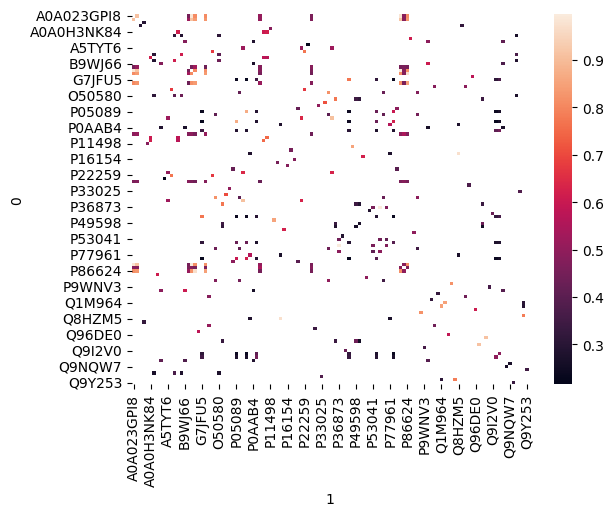

In [ ]:
df_ = df_mn.pivot(0, 1, 2)
sns.heatmap(df_)

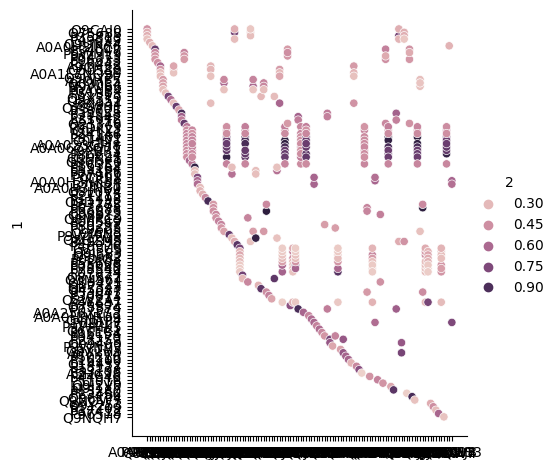

In [ ]:
sns.relplot(
    data=df_mn, x=0, y=1, hue=2,
)

In [ ]:
df_not_mn = pd.read_csv('not_mn.m8', sep="\t", header=None)

In [ ]:
df_not_mn.columns = ['Mn(2+) binding proteins', 'Non Mn(2+) binding proteins', 'Protein similarity',4,5,6,7,8,9,10,11,12]

In [ ]:
len(df_not_mn[(df_not_mn['Protein similarity'] >= 0.4) == True]['Mn(2+) binding proteins'].unique())

51

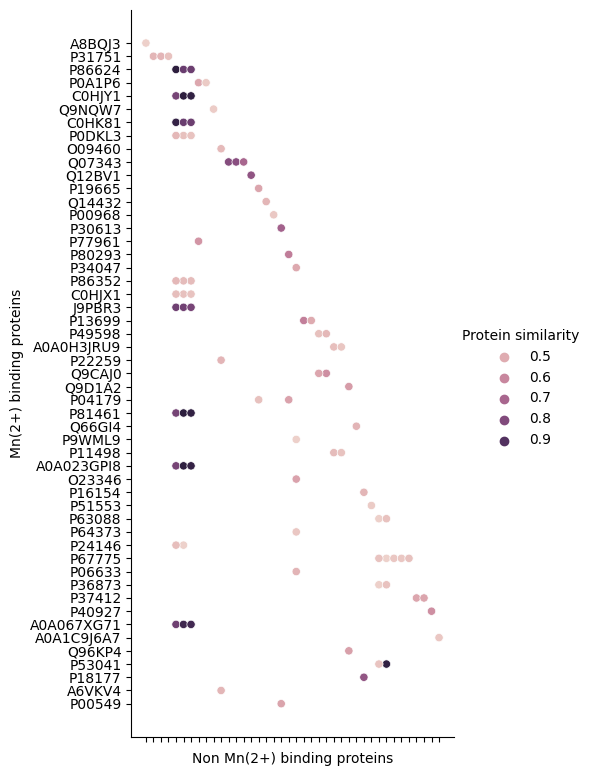

In [ ]:

p = sns.relplot(
    data=df_not_mn[(df_not_mn['Protein similarity'] > 0.4) == True], x='Non Mn(2+) binding proteins', y='Mn(2+) binding proteins', hue='Protein similarity', height = 8, aspect=5/8,
).set_xticklabels([])

In [ ]:
df_not_fe = pd.read_csv('not_fe.m8', sep="\t", header=None)

In [ ]:
df_not_fe.columns = ['Fe binding proteins', 'Non Fe binding proteins', 'Protein similarity',4,5,6,7,8,9,10,11,12]

In [ ]:
len(df_not_fe[(df_not_fe['Protein similarity'] >= 0.4) == True]['Fe binding proteins'].unique())

16

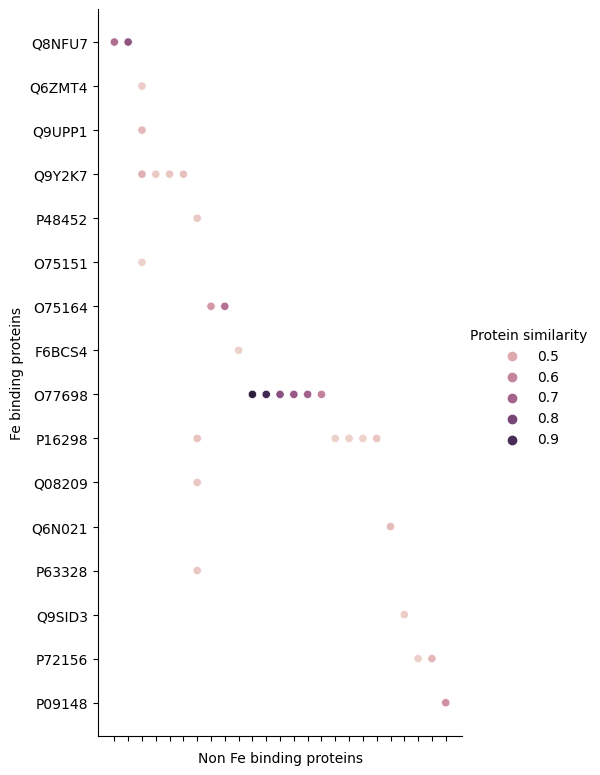

In [ ]:

p = sns.relplot(
    data=df_not_fe[(df_not_fe['Protein similarity'] > 0.4) == True], x='Non Fe binding proteins', y='Fe binding proteins', hue='Protein similarity', height = 8, aspect=5/8,
).set_xticklabels([])

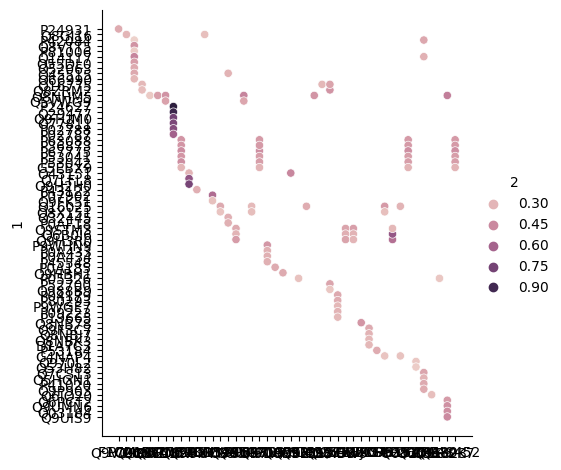

In [ ]:
sns.relplot(
    data=df_not_fe, x=, y=1, hue=2,
)

<ipython-input-32-4ab118bb7e6e>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_ = df_fe.pivot(0, 1, 2)


<Axes: xlabel='1', ylabel='0'>

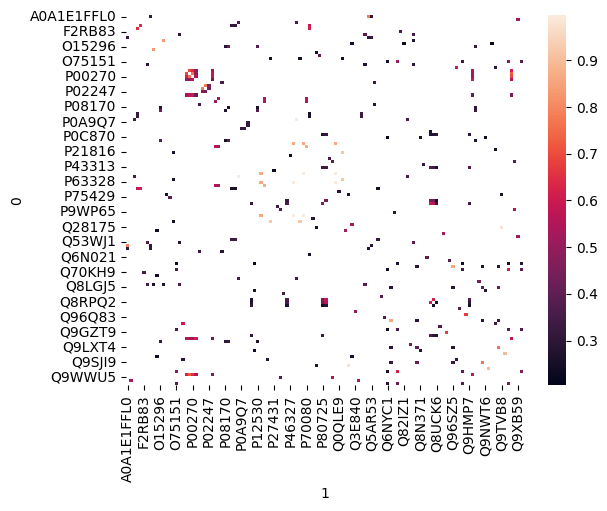

In [ ]:
df_fe = pd.read_csv('fe.m8', sep="\t", header=None)
df_fe = df_fe[df_fe[2] != 1.000]
df_ = df_fe.pivot(0, 1, 2)
sns.heatmap(df_)

In [ ]:
df_fe[2].mean()

0.4370967741935484

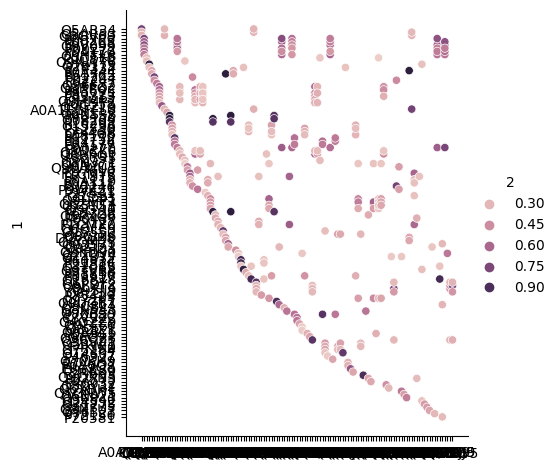

In [ ]:
sns.relplot(
    data=df_fe, x=0, y=1, hue=2,
)